# RNN with Sentimental Analysis

In [3]:
import requests
import bs4
import urllib
import webbrowser
import re
import csv
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
from matplotlib import pyplot as plt
import datetime
from datetime import date
import time
import seaborn as sns
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from pycorenlp import StanfordCoreNLP
nltk.download('vader_lexicon')
sia=SIA()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jains\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
df_sa = pd.read_csv('GoogleSentiments.csv',index_col=[0])

In [5]:
df = pd.read_csv("Google.csv",index_col = 0)
datetime.datetime.strptime(df['Date'][0],'%b %d, %Y')
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%b %d, %Y')
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df.sort_values(by='date', inplace=True, ascending=True)
df['low'] = df['low'].astype(float)
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['adj_close**'] = df['adj_close**'].astype(float)
df.drop(['close*'],axis = 1,inplace = True)
df.drop(['volume'],axis = 1, inplace = True)

In [6]:
final_scores = df_sa.iloc[:,0].values
df_rnn = df
df_rnn= df_rnn[:-2]

In [7]:
len(final_scores)

166

In [8]:
df_rnn['sentiments'] = final_scores

<ipython-input-8-23907019d286>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rnn['sentiments'] = final_scores


In [9]:
df_rnn

date     open     high      low  adj_close**  sentiments
0   2019-05-31  1105.64  1113.40  1103.35      1106.50    0.500000
1   2019-06-03  1066.93  1067.00  1027.03      1038.74    2.000000
2   2019-06-04  1044.49  1058.44  1036.03      1054.49    0.000000
3   2019-06-05  1055.00  1056.81  1033.00      1044.64    2.000000
4   2019-06-06  1046.21  1050.00  1035.51      1047.76    3.000000
..         ...      ...      ...      ...          ...         ...
161 2020-01-22  1007.25  1011.95   990.25       992.49    1.000000
162 2020-01-23   990.00  1011.05   990.00       992.29    1.000000
163 2020-01-24   995.15  1009.90   991.55       992.49    2.333333
164 2020-01-27   985.00  1005.00   985.00       986.57    1.000000
165 2020-01-28   985.00  1005.95   981.00       983.28    1.000000

[166 rows x 6 columns]

In [10]:
scaler = StandardScaler()
df_rnn = df_rnn.loc[:, ['open','high','low','adj_close**','sentiments']]
df_rnn = scaler.fit_transform(df_rnn)
df_rnn = np.array(df_rnn)

In [11]:
df_rnn

array([[ 1.32189719e-01,  8.46214515e-02,  2.15651448e-01,
         1.57233588e-01, -1.28169894e+00],
       [-2.55399430e-01, -3.91999196e-01, -5.36756617e-01,
        -5.02702289e-01,  1.19387729e+00],
       [-4.80082987e-01, -4.79927488e-01, -4.48029251e-01,
        -3.49308103e-01, -2.10689102e+00],
       [-3.74850181e-01, -4.96670842e-01, -4.77900797e-01,
        -4.45240340e-01,  1.19387729e+00],
       [-4.62861253e-01, -5.66623140e-01, -4.53155721e-01,
        -4.14853682e-01,  2.84426145e+00],
       [-3.82059279e-01, -3.25950257e-01, -2.98967276e-01,
        -2.14126433e-01,  1.19387729e+00],
       [-1.54572183e-01, -1.06026807e-01, -6.10793487e-02,
        -7.39777126e-02, -4.56506862e-01],
       [ 4.55804154e-02, -1.18325977e-02, -1.87859708e-02,
        -9.07293317e-02, -4.56506862e-01],
       [-1.25034906e-01, -2.32577807e-01, -1.17076175e-01,
        -1.09623600e-01, -4.56506862e-01],
       [-7.73747577e-02, -8.80508132e-02,  1.07898179e-02,
         6.37162312e-03

In [12]:
def get_x_y(data, N, offset):
    X, y = [], []
    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i,1])
    X = np.array(X)
    y = np.array(y)

    return X, y

In [13]:
X, y = get_x_y(df_rnn, 7, 7)

In [14]:
X.shape

(159, 7, 5)

In [15]:
X_train = []
for i in range(124):
    X_train.append(X[i])
y_train = y[:124]

X_test = []
for i in range(124, len(X)):
    X_test.append(X[i])

y_test = y[124:]

In [16]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [24]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1],5)))
model.add(Dropout(0.5)) # Add dropout with a probability of 0.5
model.add(LSTM(units=64))
model.add(Dropout(0.5)) # Add dropout with a probability of 0.5
model.add(Dense(1))

In [47]:
model.compile(loss='mean_squared_error', optimizer='RMSprop')
model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1)

Epoch 1/50
124/124 [==============================] - 4s 31ms/step - loss: 0.0483
Epoch 2/50
124/124 [==============================] - 1s 4ms/step - loss: 0.0397
Epoch 3/50
124/124 [==============================] - 1s 4ms/step - loss: 0.0448
Epoch 4/50
124/124 [==============================] - 1s 4ms/step - loss: 0.0447
Epoch 5/50
124/124 [==============================] - 1s 5ms/step - loss: 0.0393
Epoch 6/50
124/124 [==============================] - ETA: 0s - loss: 0.035 - 1s 5ms/step - loss: 0.0357
Epoch 7/50
124/124 [==============================] - 1s 4ms/step - loss: 0.0383
Epoch 8/50
124/124 [==============================] - 1s 4ms/step - loss: 0.0425
Epoch 9/50
124/124 [==============================] - 1s 5ms/step - loss: 0.0402
Epoch 10/50
124/124 [==============================] - 1s 7ms/step - loss: 0.0463
Epoch 11/50
124/124 [==============================] - 1s 8ms/step - loss: 0.0420
Epoch 12/50
124/124 [==============================] - 0s 4ms/step - loss: 0.0419


In [43]:
est = model.predict(X_test)


In [38]:
len(est)

35

In [44]:
est_df = pd.DataFrame({'est': est.reshape(-1), 
                       'date': df[-35:]['date']})
test = pd.DataFrame(columns=['date','high'])
test['date'] = df['date'][-35:]
test['high'] = y_test

Text(0, 0.5, 'USD')

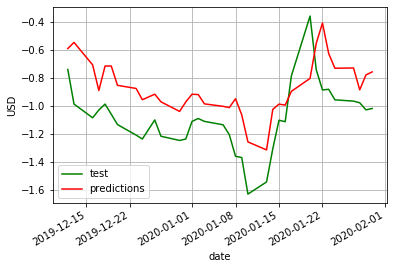

In [45]:
ax = test.plot(x='date', y='high', style='g-', grid=True)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [46]:
from sklearn.metrics import mean_squared_error
error_LR = mean_squared_error(y_test,est)
print(error_LR)

0.07182966149210342
